# 3.0 Build predictive model

In [149]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
import os

def sound():
    os.system('afplay /System/Library/Sounds/Sosumi.aiff')

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-1])
print(path)

df = pd.read_csv(path+'/data/model_data/tci_2_3.csv', dtype={'Parcel ID':str}, index_col='parcel')

print(df.shape)

/Volumes/Dropbox/largetransfer/luc/carter
(113132, 56)


In [268]:
sns.set_context('notebook')

In [150]:
t = df['c_ovv_2yr'].copy()
t[df['c_ovv_2yr']>0] = 1

print(pd.crosstab(df.vacant,t))

c_ovv_2yr       0     1
vacant                 
0          100960  2134
1            6198  3840


In [151]:
# df['missing_values'] = df.apply(lambda x: len(x[x.isnull()]),axis=1)
to_remove = ['Parcel ID','parcel','Date','Survey Category','Survey Grade',\
             'condition13', 'condition14', 'al_date']

In [152]:
features = list(df.columns.values)
for i in to_remove:
    if i in features:
        features.remove(i)

In [153]:
for i,j in enumerate(features):
    print(i,j)

0 vacant
1 propsize
2 totusabl
3 tmktval
4 condition_value13
5 condition_value14
6 style_filtered
7 ownerocc_value
8 totbldgs
9 yrbuilt_filtered
10 rextwall
11 vacant_block
12 median_rent
13 property_crimes
14 burglaries
15 part_one_crimes
16 part_two_crimes
17 bachelors+
18 poverty_rate
19 median_hh_income
20 white
21 black
22 asian
23 other
24 hispanic
25 young
26 middle
27 old
28 al_num
29 al_days
30 t_days
31 t_shf_deed
32 t_num
33 lb_acquired
34 lb_tax_fc
35 pv_total
36 v_total_1yr
37 v_total_2yr
38 c_ovv_2yr
39 c_ovv_1yr
40 active_fc
41 fc_1yr
42 fc_2yr
43 fc_days
44 sa_days
45 TAX_ASSESSED_LAND
46 TAX_MARKET_LAND
47 LENDER_PROCESS_TYPE
48 GRAND_TOTAL_BALANCE
49 GRAND_TOTAL_BALANCE_14


### Impute with median values

In [155]:
# for i in features[11:28]:
#     df.loc[df[i].isnull(),i] = np.median(df.loc[df[i].notnull(),i])

In [156]:
# # df.loc[df.propsize.isnull(),'propsize'] = np.median(df[df.propsize.notnull()].propsize)
# df.loc[df.totusabl.isnull(),'totusabl'] = np.median(df[df.totusabl.notnull()].totusabl)
# df.loc[df.tmktval.isnull(),'tmktval'] = np.median(df[df.tmktval.notnull()].tmktval)
# df.loc[df.condition_value.isnull(),'condition_value'] = np.median(df[df.condition_value.notnull()].condition_value)
# df.loc[df.condition_value13.isnull(),'condition_value13'] = np.median(df[df.condition_value13.notnull()].condition_value13)
# df.loc[df.totbldgs.isnull(),'totbldgs'] = np.median(df[df.totbldgs.notnull()].totbldgs)
# df.loc[df.yrbuilt_filtered.isnull(),'yrbuilt_filtered'] = np.median(df[df.yrbuilt_filtered.notnull()].yrbuilt_filtered)
# df.loc[df.ownerocc_value.isnull(),'ownerocc_value'] = np.median(df[df.ownerocc_value.notnull()].ownerocc_value)

In [157]:
print(df[features].columns[df[features].dtypes == 'object'])

Index(['style_filtered', 'rextwall', 'LENDER_PROCESS_TYPE'], dtype='object')


In [158]:
# transform categorical variables (including NaN's)
objs = df[features].columns[df[features].dtypes == 'object']
prefixes = ['style','ext','lender']

df2 = df[objs]
df3 = pd.concat([pd.get_dummies(df2[col], prefix=prefixes[index]) for index, col in enumerate(df2)], axis=1)

for i in objs:
    features.remove(i)
    
df3[features] = df[features]
df3 = df3.fillna(0)

print(df3.shape)

(113132, 60)


## Build the classifiers

In [159]:
df

,vacant,Date,Survey Category,Survey Grade,propsize,totusabl,tmktval,condition13,condition14,condition_value13,...,active_fc,fc_1yr,fc_2yr,fc_days,sa_days,TAX_ASSESSED_LAND,TAX_MARKET_LAND,LENDER_PROCESS_TYPE,GRAND_TOTAL_BALANCE,GRAND_TOTAL_BALANCE_14
parcel,,,,,,,,,,,,,,,,,,,,,
001-01-001,0,2015-08-10 15:05:00,Occupied Structure,A,32768,4149,445500,Average,Average,5,...,0,0,0,3560,3561,117430,335500,0,0.00,0.00
001-01-003,0,2015-08-10 15:09:00,Occupied Structure,A,81536,15828,1159600,Excellent,Excellent,8,...,0,0,0,3560,3561,139020,397200,0,16529.99,0.00
001-01-004,0,2015-08-10 15:06:00,Occupied Structure,A,13832,2537,266300,Good,Good,6,...,0,0,0,3560,3561,27690,79100,1501,3780.63,0.00
001-01-005,0,2015-08-10 15:07:00,Occupied Structure,B,10500,1578,171700,Good,Good,6,...,0,0,0,3560,3561,24050,68700,None,2082.77,2505.28
001-01-006,0,2015-08-10 15:10:00,Occupied Structure,A,16500,3650,296200,Excellent,Excellent,8,...,0,0,0,3560,3561,30700,87700,1501,4205.30,0.00
001-01-007,0,2015-08-10 15:11:00,Occupied Structure,A,12000,3300,324900,Very good,Very good,7,...,0,0,0,3560,3561,25730,73500,None,4257.61,0.00
001-01-008,0,2015-08-10 15:12:00,Occupied Structure,A,12000,2160,350500,Very good,Very good,7,...,0,0,0,3560,3561,25730,73500,None,5476.60,0.00
001-01-009,0,2015-08-10 10:39:00,Occupied Structure,A,11250,3590,365000,Good,Good,6,...,0,0,0,3560,3561,23630,67500,1501,5181.99,0.00
001-01-010,0,2015-08-10 10:38:00,Occupied Structure,A,11250,2576,274900,Good,Good,6,...,0,0,0,3560,3561,23630,67500,1501,3902.70,0.00


In [160]:
# train and test the classifier, look at results in a cross tabulation
# take out some of the data for the test set

df3['is_train'] = np.random.uniform(0, 1, len(df3)) <= .8
train, test = df3[df3['is_train']==True], df3[df3['is_train']==False]
 
features = list(df3.columns)
features.remove('vacant')

y, _ = pd.factorize(train['vacant'])
test_label = test.vacant

### Random Forest Classifier

In [161]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, min_samples_split=2, \
                                 class_weight={0:1, 1:1}, \
                                 max_features=None, random_state=0, max_depth=30)
rfc = rfc.fit(train[features], y)
sound()
print(pd.crosstab(test.vacant, rfc.predict(test[features])))

col_0       0    1
vacant            
0       20249  298
1        1066  964


In [355]:
test

,style_Bungalow,style_CAP,style_Colonial,style_Other,style_Ranch,ext_Aluminum/Vinyl (r),ext_Brick,ext_Frame (r),ext_Other,lender_0,...,fc_1yr,fc_2yr,fc_days,sa_days,TAX_ASSESSED_LAND,TAX_MARKET_LAND,GRAND_TOTAL_BALANCE,GRAND_TOTAL_BALANCE_14,is_train,SPA_NAME
parcel,,,,,,,,,,,,,,,,,,,,,
001-01-005,0,1,0,0,0,1,0,0,0,0,...,0,0,3560,3561,24050,68700,2082.77,2505.28,False,Edgewater
001-01-014,0,0,0,0,1,0,1,0,0,0,...,0,0,3560,3561,23310,66600,2732.85,2625.23,False,Edgewater
001-01-017,0,0,0,0,1,0,1,0,0,0,...,0,0,3560,3561,22820,65200,2991.75,0.00,False,Edgewater
001-01-026,0,0,1,0,0,0,0,1,0,0,...,0,0,3560,3561,22650,64700,2707.41,0.00,False,Edgewater
001-01-032,0,0,0,0,1,0,0,1,0,1,...,0,0,3560,3561,24430,69800,2930.08,0.00,False,Edgewater
001-01-037,0,0,1,0,0,0,1,0,0,0,...,0,0,3560,3561,29650,84700,5315.44,0.00,False,Edgewater
001-01-042,0,0,0,1,0,0,1,0,0,0,...,0,0,3560,3561,25830,73800,1834.13,0.00,False,Edgewater
001-02-006,0,0,1,0,0,0,0,0,1,0,...,0,0,3560,3561,274440,784100,16367.67,0.00,False,Edgewater
001-02-013,0,0,1,0,0,0,1,0,0,0,...,0,0,3560,3561,29720,84900,4957.68,0.00,False,Edgewater


In [356]:
test['prob'] = rfc.predict_proba(test[features])[:,1]

In [174]:
test.preds = rfc.predict(test[features])

In [166]:
true_pos = test[(test.preds==1) & (test.vacant==1)].index
false_neg = test[(test.preds==0) & (test.vacant==1)].index

In [168]:
tci = pd.read_csv(path+'/data/model_data/tci_1_0.csv', parse_dates=['Date'], dtype={'PIN': str})

In [171]:
test = pd.merge(test, tci[['parcel','SPA_NAME']].set_index('parcel'), how='left', left_index=True, right_index=True)

In [195]:
counts = test.loc[(test.preds==0) & (test.vacant==1),['SPA_NAME','is_train']].groupby('SPA_NAME').count()
counts = counts.rename(columns={'is_train':'false_negative'})
counts['true_positive']=test.loc[(test.preds==1) & (test.vacant==1),['SPA_NAME','is_train']].groupby('SPA_NAME').count()
counts['false_positive']=test.loc[(test.preds==1) & (test.vacant==0),['SPA_NAME','is_train']].groupby('SPA_NAME').count()
counts['number']=test[['SPA_NAME','is_train']].groupby('SPA_NAME').count()
counts = counts.fillna(0)
counts['ratio'] = counts['true_positive']/counts['false_negative']

In [329]:
pd.set_option('precision',3)

In [333]:
test.columns

Index(['style_Bungalow', 'style_CAP', 'style_Colonial', 'style_Other',
       'style_Ranch', 'ext_Aluminum/Vinyl (r)', 'ext_Brick', 'ext_Frame (r)',
       'ext_Other', 'lender_0', 'lender_1501', 'lender_2500', 'lender_None',
       'vacant', 'propsize', 'totusabl', 'tmktval', 'condition_value13',
       'condition_value14', 'ownerocc_value', 'totbldgs', 'yrbuilt_filtered',
       'vacant_block', 'median_rent', 'property_crimes', 'burglaries',
       'part_one_crimes', 'part_two_crimes', 'bachelors+', 'poverty_rate',
       'median_hh_income', 'white', 'black', 'asian', 'other', 'hispanic',
       'young', 'middle', 'old', 'al_num', 'al_days', 't_days', 't_shf_deed',
       't_num', 'lb_acquired', 'lb_tax_fc', 'pv_total', 'v_total_1yr',
       'v_total_2yr', 'c_ovv_2yr', 'c_ovv_1yr', 'active_fc', 'fc_1yr',
       'fc_2yr', 'fc_days', 'sa_days', 'TAX_ASSESSED_LAND', 'TAX_MARKET_LAND',
       'GRAND_TOTAL_BALANCE', 'GRAND_TOTAL_BALANCE_14', 'is_train',
       'SPA_NAME'],
      dtype='ob

In [409]:
cols = ['GRAND_TOTAL_BALANCE','TAX_MARKET_LAND','sa_days','fc_days','c_ovv_2yr','pv_total',\
        'tmktval','propsize','condition_value14','median_rent']
test.loc[(test.SPA_NAME=='Glenville') & (test.vacant==0),cols].describe()

,GRAND_TOTAL_BALANCE,TAX_MARKET_LAND,sa_days,fc_days,c_ovv_2yr,pv_total,tmktval,propsize,condition_value14,median_rent
count,1403.000,1403.000,1403.000,1403.000,1403.000,1403.000,1403.000,1403.000,1403.000,1403.000
mean,1354.675,5485.816,3360.661,3149.508,0.239,0.861,29051.033,4568.086,4.364,689.695
std,2872.265,6000.181,687.318,853.136,2.517,2.423,18474.881,2453.764,0.887,98.842
min,0.000,0.000,28.000,17.000,0.000,0.000,0.000,1225.000,0.000,467.000
25%,128.790,2500.000,3561.000,3440.000,0.000,0.000,19800.000,3640.000,4.000,641.000
50%,394.640,3200.000,3561.000,3560.000,0.000,0.000,25800.000,4200.000,4.000,689.000
75%,999.140,7400.000,3561.000,3560.000,0.000,0.000,36450.000,4995.000,5.000,732.000
max,25939.160,71600.000,5553.000,3560.000,82.000,10.000,445600.000,58800.000,8.000,842.000


In [408]:
test.loc[(test.SPA_NAME=='Glenville')  & (test.vacant==1),cols].describe()

,GRAND_TOTAL_BALANCE,TAX_MARKET_LAND,sa_days,fc_days,c_ovv_2yr,pv_total,tmktval,propsize,condition_value14,median_rent
count,311.000,311.000,311.000,311.000,311.000,311.000,311.000,311.000,311.000,311.000
mean,6083.555,4344.695,2939.164,2546.457,4.897,5.595,23453.698,4269.762,3.338,697.315
std,7073.443,3436.431,1045.474,1126.218,7.378,4.463,12894.487,1498.149,1.272,88.240
min,0.000,0.000,49.000,5.000,0.000,0.000,0.000,1404.000,0.000,467.000
25%,459.820,2400.000,2611.500,1611.000,0.000,0.000,14750.000,3602.500,3.000,642.000
50%,2866.940,3100.000,3561.000,2999.000,0.000,7.000,22100.000,4107.000,3.000,713.000
75%,9980.605,6500.000,3561.000,3560.000,9.000,10.000,30500.000,4800.000,4.000,732.000
max,44469.310,44100.000,5539.000,3560.000,51.000,10.000,95200.000,19380.000,6.000,842.000


In [261]:
pd.crosstab(test.vacant, test.preds)

col_0,0,1
vacant,,
0,20249,298
1,1066,964


In [275]:
counts['missing_pct'] = counts['false_negative']/(counts['false_negative']+counts['true_positive'])

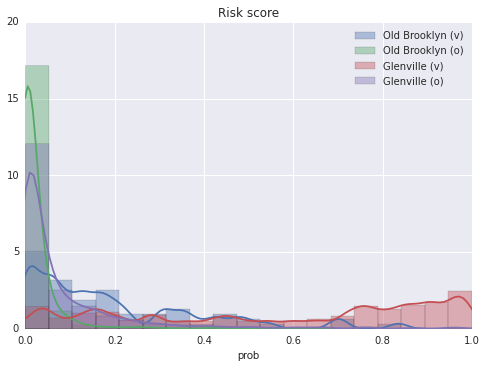

In [388]:
# old brooklyn
sns_plot = plt.figure()
sns.distplot(test.loc[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==1),'prob'], \
             bins=np.linspace(0,1,20), kde_kws={'bw':.02})
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==0)]['prob'], \
             bins=np.linspace(0,1,20), kde_kws={'bw':.02})
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==1)]['prob'], \
             bins=np.linspace(0,1,20), kde_kws={'bw':.02})
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==0)]['prob'], \
             bins=np.linspace(0,1,20), kde_kws={'bw':.02})

plt.axis([0,1,0,20])
plt.legend(['Old Brooklyn (v)','Old Brooklyn (o)','Glenville (v)','Glenville (o)'])
plt.title('Risk score');
sns_plot.savefig(path+"/outputs/vacant/prob_comp.png")

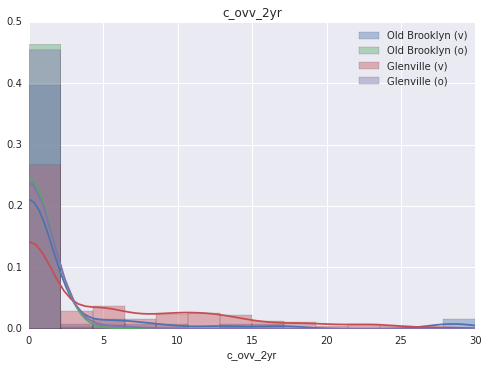

In [350]:
# old brooklyn
sns_plot = plt.figure()
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==1)].c_ovv_2yr, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1.6}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==0)].c_ovv_2yr, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1.6}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==1)].c_ovv_2yr, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1.6}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==0)].c_ovv_2yr, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1.6}, norm_hist=True)

plt.axis([0,30,0,0.5])
plt.legend(['Old Brooklyn (v)','Old Brooklyn (o)','Glenville (v)','Glenville (o)'])
plt.title('c_ovv_2yr');
sns_plot.savefig(path+"/outputs/vacant/c_ovv_2yr_comp.png")

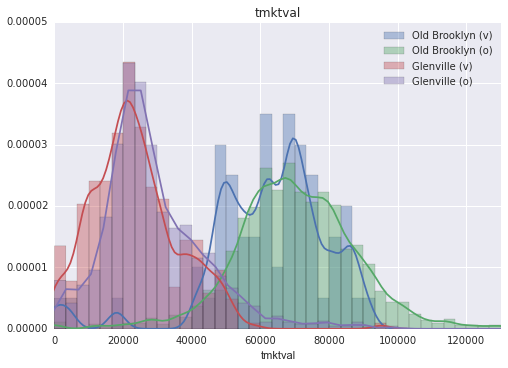

In [347]:
sns_plot = plt.figure()
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==1)].tmktval, \
             bins=np.linspace(0,130000,40), kde_kws={'bw':2500}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==0)].tmktval, \
             bins=np.linspace(0,130000,40), kde_kws={'bw':2500}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==1)].tmktval, \
             bins=np.linspace(0,130000,40), kde_kws={'bw':2500}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==0)].tmktval, \
             bins=np.linspace(0,130000,40), kde_kws={'bw':2500}, norm_hist=True)

plt.axis([0,130000,0,0.00005])
plt.legend(['Old Brooklyn (v)','Old Brooklyn (o)','Glenville (v)','Glenville (o)'])
plt.title('tmktval');
sns_plot.savefig(path+"/outputs/vacant/tmktval_comp.png")

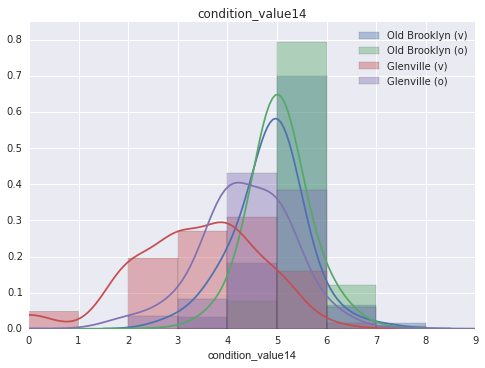

In [405]:
sns_plot = plt.figure()

sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==1)].condition_value14, \
             bins=np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==0)].condition_value14, \
             bins=np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==1)].condition_value14, \
             bins=np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==0)].condition_value14, \
             bins=np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True)

plt.axis([0,9,0,0.85])
plt.legend(['Old Brooklyn (v)','Old Brooklyn (o)','Glenville (v)','Glenville (o)'])
plt.title('condition_value14');

sns_plot.savefig(path+"/outputs/vacant/condition_value14_comp.png")

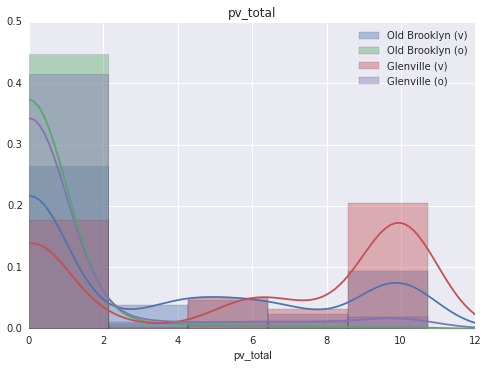

In [348]:
sns_plot = plt.figure()

sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==1)].pv_total, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==0)].pv_total, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==1)].pv_total, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==0)].pv_total, \
             bins=np.linspace(0,30,15), kde_kws={'bw':1}, norm_hist=True)

plt.axis([0,12,0,0.5])
plt.legend(['Old Brooklyn (v)','Old Brooklyn (o)','Glenville (v)','Glenville (o)'])
plt.title('pv_total');

sns_plot.savefig(path+"/outputs/vacant/pv_total_comp.png")

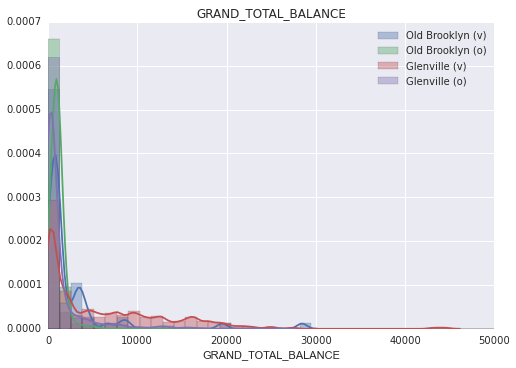

In [349]:
sns_plot = plt.figure()
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==1)].GRAND_TOTAL_BALANCE, \
             bins=np.linspace(0,50000,40), kde_kws={'bw':550}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Old Brooklyn') & (test.vacant==0)].GRAND_TOTAL_BALANCE, \
             bins=np.linspace(0,50000,40), kde_kws={'bw':550}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==1)].GRAND_TOTAL_BALANCE, \
             bins=np.linspace(0,50000,40), kde_kws={'bw':550}, norm_hist=True)
sns.distplot(test[(test.SPA_NAME=='Glenville') & (test.vacant==0)].GRAND_TOTAL_BALANCE, \
             bins=np.linspace(0,50000,40), kde_kws={'bw':550}, norm_hist=True)

plt.axis([0,50000,0,0.0007])
plt.legend(['Old Brooklyn (v)','Old Brooklyn (o)','Glenville (v)','Glenville (o)'])
plt.title('GRAND_TOTAL_BALANCE');
sns_plot.savefig(path+"/outputs/vacant/grand_comp.png")

In [276]:
counts.sort_values('missing_pct', ascending=False)

,false_negative,true_positive,false_positive,number,ratio,missing_pct
SPA_NAME,,,,,,
Ohio City,18,1,3,320,0.055556,0.947368
Kamm's,30,2,1,1805,0.066667,0.937500
Tremont,12,1,2,391,0.083333,0.923077
Old Brooklyn,55,5,3,2243,0.090909,0.916667
Jefferson,29,3,3,1259,0.103448,0.906250
Lee-Harvard,48,10,7,918,0.208333,0.827586
Bellaire-Puritas,29,7,7,1012,0.241379,0.805556
Clark-Fulton,26,7,6,417,0.269231,0.787879
Central,13,5,3,172,0.384615,0.722222


In [ ]:
# 1. feature 48, c_ovv_2yr (0.291295)
# 2. feature 45, pv_total (0.123032)
# 3. feature 57, GRAND_TOTAL_BALANCE (0.076631)
# 4. feature 17, condition_value14 (0.043401)
# 5. feature 15, tmktval (0.030920)
# 6. feature 54, sa_days (0.030771)
# 7. feature 14, totusabl (0.029601)
# 8. feature 39, al_days (0.027017)
# 9. feature 58, GRAND_TOTAL_BALANCE_14 (0.026274)
# 10. feature 53, fc_days (0.023580)

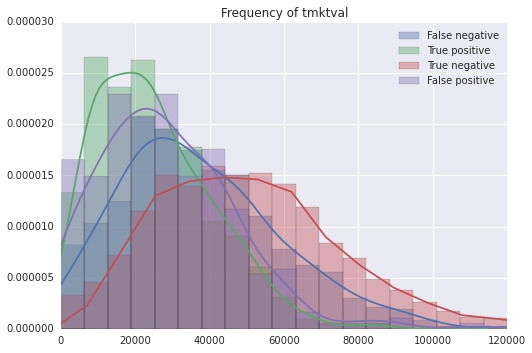

In [269]:
sns_plot = plt.figure()
sns.distplot(test[(test.vacant==1) & (test.preds==0)].tmktval.values, bins = np.linspace(0,120000,20), norm_hist=True);
sns.distplot(test[(test.vacant==1) & (test.preds==1)].tmktval.values, bins = np.linspace(0,120000,20), norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==0)].tmktval.values, bins = np.linspace(0,120000,20), norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==1)].tmktval.values, bins = np.linspace(0,120000,20), norm_hist=True);
plt.axis([0,120000,0,0.00003])
plt.legend(['False negative','True positive','True negative','False positive'])
plt.title('Frequency of tmktval');
sns_plot.savefig(path+"/outputs/vacant/tmktval.png")

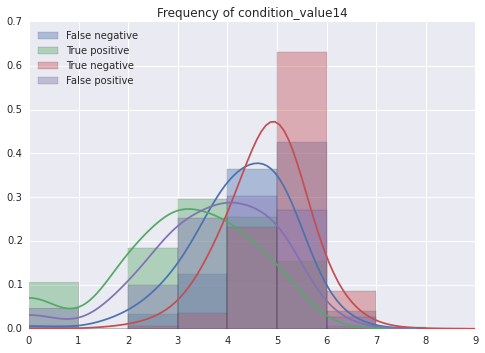

In [270]:
sns_plot = plt.figure()
sns.distplot(test[(test.vacant==1) & (test.preds==0)].condition_value14.values, bins = np.linspace(0,8,9), kde_kws={'bw':.6}, norm_hist=True);
sns.distplot(test[(test.vacant==1) & (test.preds==1)].condition_value14.values, bins = np.linspace(0,8,9), kde_kws={'bw':.6}, norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==0)].condition_value14.values, bins = np.linspace(0,8,9), kde_kws={'bw':.6}, norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==1)].condition_value14.values, bins = np.linspace(0,8,9), kde_kws={'bw':.6}, norm_hist=True);
plt.axis([0,9,0,0.7]);
plt.legend(['False negative','True positive','True negative','False positive'],loc='upper left');
plt.title('Frequency of condition_value14');
sns_plot.savefig(path+"/outputs/vacant/condition_value14.png")

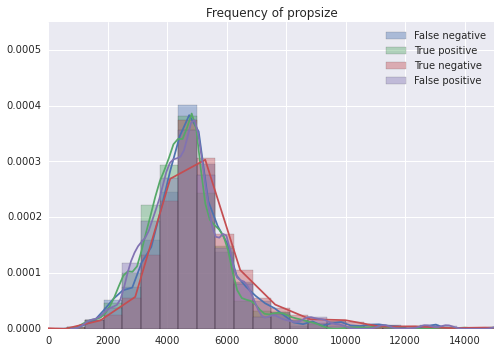

In [271]:
sns_plot = plt.figure()
sns.distplot(test[(test.vacant==1) & (test.preds==0)].propsize.values, kde_kws={'bw':200}, bins = np.linspace(0,15000,25), norm_hist=True);
sns.distplot(test[(test.vacant==1) & (test.preds==1)].propsize.values, kde_kws={'bw':200}, bins = np.linspace(0,15000,25), norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==0)].propsize.values, kde_kws={'bw':200},bins = np.linspace(0,15000,25), norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==1)].propsize.values, kde_kws={'bw':200},bins = np.linspace(0,15000,25), norm_hist=True);

plt.legend(['False negative','True positive','True negative','False positive'],loc='upper right');
plt.axis([0,15000,0,0.00055])
plt.title('Frequency of propsize');
sns_plot.savefig(path+"/outputs/vacant/propsize.png")

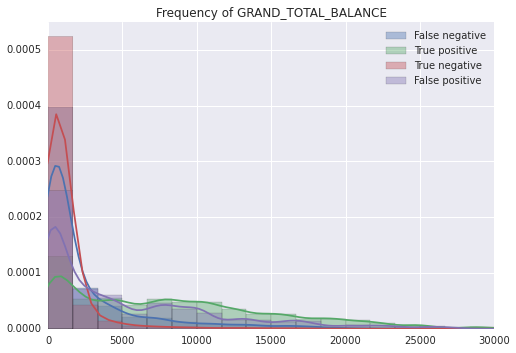

In [272]:
sns_plot = plt.figure()
sns.distplot(test[(test.vacant==1) & (test.preds==0)].GRAND_TOTAL_BALANCE.values, kde_kws={'bw':800}, bins = np.linspace(0,40000,25), norm_hist=True);
sns.distplot(test[(test.vacant==1) & (test.preds==1)].GRAND_TOTAL_BALANCE.values, kde_kws={'bw':800}, bins = np.linspace(0,40000,25), norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==0)].GRAND_TOTAL_BALANCE.values, kde_kws={'bw':800},bins = np.linspace(0,40000,25), norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==1)].GRAND_TOTAL_BALANCE.values, kde_kws={'bw':800},bins = np.linspace(0,40000,25), norm_hist=True);

plt.legend(['False negative','True positive','True negative','False positive'],loc='upper right');
plt.axis([0,30000,0,0.00055])
plt.title('Frequency of GRAND_TOTAL_BALANCE');
sns_plot.savefig(path+"/outputs/vacant/grand_total_balance.png")

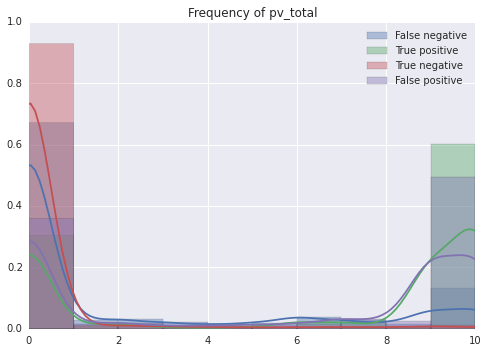

In [273]:
sns_plot = plt.figure()
sns.distplot(test[(test.vacant==1) & (test.preds==0)].pv_total.values, bins = np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True);
sns.distplot(test[(test.vacant==1) & (test.preds==1)].pv_total.values, bins = np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==0)].pv_total.values, bins = np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==1)].pv_total.values, bins = np.linspace(0,10,11), kde_kws={'bw':0.5}, norm_hist=True);

plt.legend(['False negative','True positive','True negative','False positive'],loc='upper right');
plt.axis([0,10,0,1])

plt.title('Frequency of pv_total');
sns_plot.savefig(path+"/outputs/vacant/pv.png")

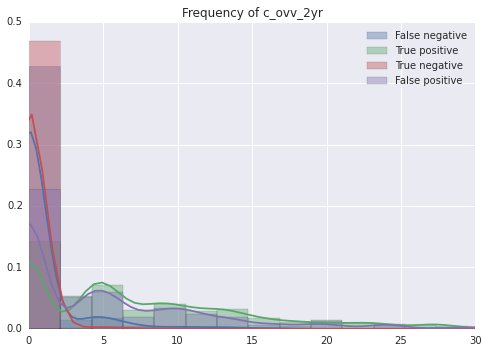

In [274]:
sns_plot = plt.figure()
sns.distplot(test[(test.vacant==1) & (test.preds==0)].c_ovv_2yr.values, bins = np.linspace(0,40,20), kde_kws={'bw':1.1}, norm_hist=True);
sns.distplot(test[(test.vacant==1) & (test.preds==1)].c_ovv_2yr.values, bins = np.linspace(0,40,20), kde_kws={'bw':1.1}, norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==0)].c_ovv_2yr.values, bins = np.linspace(0,40,20), kde_kws={'bw':1.1}, norm_hist=True);
sns.distplot(test[(test.vacant==0) & (test.preds==1)].c_ovv_2yr.values, bins = np.linspace(0,40,20), kde_kws={'bw':1.1}, norm_hist=True);
plt.legend(['False negative','True positive','True negative','False positive'],loc='upper right');
plt.title('Frequency of c_ovv_2yr');
plt.axis([0,30,0,0.5])

sns_plot.savefig(path+"/outputs/vacant/ovv.png")

In [18]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=9, min_samples_split=2, \
                                 class_weight={0:1, 1:3}, \
                                 max_features=None, random_state=0, max_depth=40)
rfc = rfc.fit(train[features2], y)
sound()
print(pd.crosstab(test.vacant, rfc.predict(test[features2])))

col_0       0     1
vacant             
0       20110   547
1         896  1134


In [19]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=9, min_samples_split=2, \
                                 class_weight={0:1, 1:3}, \
                                 max_features=None, random_state=0, max_depth=40)
rfc = rfc.fit(train[features], y)
sound()
print(pd.crosstab(test.vacant, rfc.predict(test[features])))

col_0       0     1
vacant             
0       20110   547
1         894  1136


In [68]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rf_fpr, rf_tpr, thresholds = roc_curve(test.vacant, rfc.predict_proba(test[features])[:,1])
lr_fpr, lr_tpr, thresholds = roc_curve(test.vacant, lr.predict_proba(test_lr)[:,1])

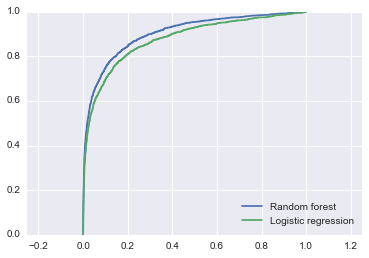

In [73]:
plt.plot(rf_fpr,rf_tpr);
plt.plot(lr_fpr,lr_tpr);
plt.axis('equal');
plt.axis([0,1,0,1]);
plt.legend(['Random forest','Logistic regression'],loc='lower right');

In [144]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, min_samples_split=2, \
                                 class_weight={0:1, 1:25}, \
                                 max_features=None, random_state=0, max_depth=40)
rfc = rfc.fit(train[features2], y)
sound()
print(pd.crosstab(test.vacant, rfc.predict(test[features2])))

col_0       0     1
vacant             
0       19604   808
1         782  1214


In [91]:
print(pd.crosstab(test.vacant, rfc.predict(test[features])))
# print(pd.crosstab(tem.vacant, (tem['prob']+0.15).apply(round)))

col_0       0     1
vacant             
0       30308   436
1        1608  1443


In [157]:
rfc_prob = rfc.predict_proba(test[features])

tem = test.copy()
tem['prob'] = rfc_prob[:,1]
tem['pred'] = tem.prob.apply(round)
plt.hist(tem[tem.vacant==1].prob.values,alpha=0.5,normed=True, bins=20);
plt.hist(tem[tem.vacant==0].prob.values,alpha=0.5,normed=True, bins=20);
print(sum(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant)*1.0/sum(tem.vacant))
pd.crosstab(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant,tem.sort_values('prob', ascending=False).iloc[0:5000].pred)

Traceback (most recent call last):
  File "//anaconda/envs/vacancy/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-158-1d7b65407729>", line 1, in <module>
    rfc_prob = rfc.predict_proba(test[features])
  File "//anaconda/envs/vacancy/lib/python3.4/site-packages/sklearn/ensemble/forest.py", line 513, in predict_proba
    for e in self.estimators_)
  File "//anaconda/envs/vacancy/lib/python3.4/site-packages/sklearn/externals/joblib/parallel.py", line 659, in __call__
    self.dispatch(function, args, kwargs)
  File "//anaconda/envs/vacancy/lib/python3.4/site-packages/sklearn/externals/joblib/parallel.py", line 406, in dispatch
    job = ImmediateApply(func, args, kwargs)
  File "//anaconda/envs/vacancy/lib/python3.4/site-packages/sklearn/externals/joblib/parallel.py", line 140, in __init__
    self.results = func(*args, **kwargs)
  File "//anaconda/envs/vacancy/lib/python3

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

0.735496558505


pred,0.0,1.0
vacant,,
0,2321,435
1,829,1415


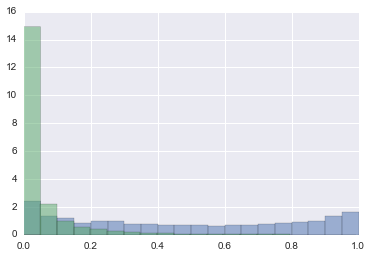

In [98]:
rfc_prob = rfc.predict_proba(test[features2])

tem = test.copy()
tem['prob'] = rfc_prob[:,1]
tem['pred'] = tem.prob.apply(round)
plt.hist(tem[tem.vacant==1].prob.values,alpha=0.5,normed=True, bins=20);
plt.hist(tem[tem.vacant==0].prob.values,alpha=0.5,normed=True, bins=20);
print(sum(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant)*1.0/sum(tem.vacant))
pd.crosstab(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant,tem.sort_values('prob', ascending=False).iloc[0:5000].pred)

#### Parameter search

In [29]:
# depth_range = range(10,40,2)
# scores = []
# for depth in depth_range:
#     rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, \
#                                  class_weight='auto', \
#                                  max_features=None, random_state=0, max_depth=depth)
#     scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
# plt.plot(depth_range, scores, '--');
# # plt.ylim(0,1);
# plt.title('Accuracy by max depth range');

Feature ranking:
1. feature 48, c_ovv_2yr (0.291295)
2. feature 45, pv_total (0.123032)
3. feature 57, GRAND_TOTAL_BALANCE (0.076631)
4. feature 17, condition_value14 (0.043401)
5. feature 15, tmktval (0.030920)
6. feature 54, sa_days (0.030771)
7. feature 14, totusabl (0.029601)
8. feature 39, al_days (0.027017)
9. feature 58, GRAND_TOTAL_BALANCE_14 (0.026274)
10. feature 53, fc_days (0.023580)
11. feature 13, propsize (0.023026)
12. feature 20, yrbuilt_filtered (0.016491)
13. feature 42, t_num (0.015791)
14. feature 40, t_days (0.011725)
15. feature 56, TAX_MARKET_LAND (0.011364)
16. feature 21, vacant_block (0.011012)
17. feature 22, median_rent (0.010609)
18. feature 55, TAX_ASSESSED_LAND (0.010597)
19. feature 27, bachelors+ (0.010532)
20. feature 24, burglaries (0.009841)


//anaconda/envs/vacancy/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


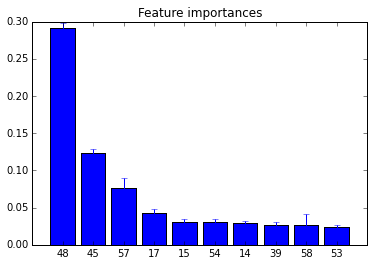

In [17]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

In [16]:
features2 = pd.DataFrame(features).iloc[indices[0:20]][0].values

Feature ranking (least important):
1. feature 59, is_train (0.000000)
2. feature 43, lb_acquired (0.000000)
3. feature 44, lb_tax_fc (0.000060)
4. feature 51, fc_1yr (0.000098)
5. feature 52, fc_2yr (0.000136)
6. feature 0, style__Bungalow (0.000374)
7. feature 50, active_fc (0.000428)
8. feature 8, ext__Other (0.000474)
9. feature 4, style__Ranch (0.000628)
10. feature 11, lender__2500 (0.000747)
11. feature 6, ext__Brick (0.000880)
12. feature 49, c_ovv_1yr (0.000959)
13. feature 3, style__Other (0.001061)
14. feature 2, style__Colonial (0.001430)
15. feature 1, style__CAP (0.001576)
16. feature 9, lender__0 (0.001831)
17. feature 7, ext__Frame (r) (0.001991)
18. feature 10, lender__1501 (0.002010)
19. feature 5, ext__Aluminum/Vinyl (r) (0.002152)
20. feature 12, lender__None (0.002754)


//anaconda/envs/vacancy/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


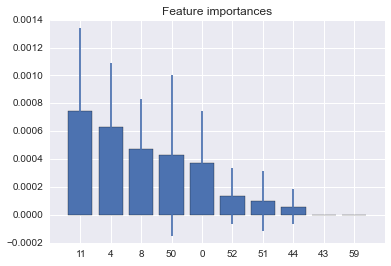

In [34]:
# Print the feature ranking
print("Feature ranking (least important):")

for f in range(20):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[-10:]], yerr=std[indices[-10:]], align="center")
plt.xticks(range(10), indices[-10:])
plt.xlim([-1, 10])
plt.show()

### Logistic Regressor

In [214]:
# features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant',\
#              'totusabl', 'tmktval', 'fc_days', 'days_since_transfer', 'propsize', 'yrbuilt_filtered', 'al_days']

# features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant']

In [67]:
train_lr = preprocessing.scale(train[features2])
test_lr = preprocessing.scale(test[features2])

In [56]:
lr = LogisticRegression(class_weight={0:1, 1:1}, random_state=1001)
lr.fit(pd.DataFrame(train_lr, columns = features2), y)
pd.crosstab(test.vacant,lr.predict(test_lr))

col_0,0,1
vacant,,
0,20368,405
1,1114,922


In [60]:
lr.predict_proba(train[features2])

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [49]:
lr.score(train[features2], train.vacant)

0.91166148157169269

In [134]:
lr.score(test[features2], test.vacant)

0.91119243127454486

0.795090180361


pred,0.0,1.0
vacant,,
0,2429,984
1,361,1226


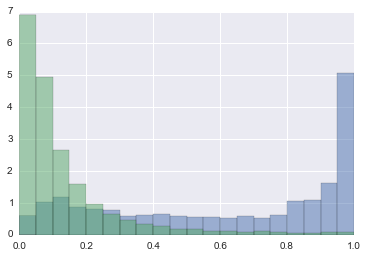

In [132]:
lr_prob = lr.predict_proba(test_lr)

tem = test.copy()
tem['prob'] = lr_prob[:,1]
tem['pred'] = tem.prob.apply(round)
plt.hist(tem[tem.vacant==1].prob.values,alpha=0.5,normed=True, bins=20);
plt.hist(tem[tem.vacant==0].prob.values,alpha=0.5,normed=True, bins=20);
print(sum(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant)*1.0/sum(tem.vacant))
pd.crosstab(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant,tem.sort_values('prob', ascending=False).iloc[0:5000].pred)

In [209]:
pd.crosstab(test['vacant'], lr.predict(pd.DataFrame(test_lr, columns = features2)), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,30081,870
1,1477,1541


In [126]:
pd.crosstab(test['vacant'], lr.predict(pd.DataFrame(test_lr, columns = features2)), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,29883,1031
1,1424,1653


In [56]:
pd.crosstab(test['vacant'], lr.predict(pd.DataFrame(test_lr, columns = features)), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,30714,336
1,1877,1192


In [139]:
importances = lr.coef_[0]
# std = np.std([tree.feature_importances_ for tree in lr.estimators_],
#              axis=0)
indices = np.argsort(abs(importances))[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(features2)):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features2[indices[f]], importances[indices[f]]))
print("\nFeature ranking (least important):")
for f in range(len(features2)):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features2[indices[-f-1]], importances[indices[-f-1]]))

Feature ranking:
1. feature 10, propsize (-1.093358)
2. feature 1, pv_total (0.495365)
3. feature 0, c_ovv_2yr (0.480271)
4. feature 5, condition_value14 (-0.437575)
5. feature 3, GRAND_TOTAL_BALANCE (0.403404)
6. feature 6, tmktval (-0.401223)
7. feature 2, fc_days (-0.352014)
8. feature 7, sa_days (-0.166370)
9. feature 15, vacant_block (0.164420)
10. feature 9, al_days (0.118188)
11. feature 16, t_days (0.108253)
12. feature 8, totusabl (0.061968)
13. feature 18, median_hh_income (-0.059149)
14. feature 4, GRAND_TOTAL_BALANCE_14 (-0.049359)
15. feature 12, t_num (0.048948)
16. feature 17, median_rent (-0.032740)
17. feature 19, bachelors+ (0.027363)
18. feature 11, yrbuilt_filtered (-0.024315)
19. feature 14, TAX_MARKET_LAND (0.006594)
20. feature 13, TAX_ASSESSED_LAND (0.006268)

Feature ranking (least important):
1. feature 13, TAX_ASSESSED_LAND (0.006268)
2. feature 14, TAX_MARKET_LAND (0.006594)
3. feature 11, yrbuilt_filtered (-0.024315)
4. feature 19, bachelors+ (0.027363)
5. 

### Adaboost Classifier

In [235]:
from sklearn.ensemble import AdaBoostClassifier

In [236]:
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
abc.fit(train[features], y)

KeyError: "['deed__Other' 'deed__Quit Claim Deed' 'deed__Quit Claim Deed Ex'\n 'deed__Sheriffs Deed' 'deed__Survivorship Deed' 'deed__Warranty Deed'\n 'lender__0.0' 'lender__1501.0' 'lender__2500.0' 'lender__None'\n 'ext__Aluminum/Vinyl (r)' 'ext__Brick' 'ext__Frame (r)' 'ext__Other'\n 'style__Bungalow' 'style__Colonial' 'style__Other' 'style__Ranch'\n 'style__Split level' 'style__Townhouse' 'condition_value13'\n 'ownerocc_value' 'totbldgs' 'vacant_block' 'median_rent' 'property_crimes'\n 'burglaries' 'part_one_crimes' 'part_two_crimes' 'bachelors+'\n 'poverty_rate' 'median_hh_income' 'white' 'black' 'asian' 'other'\n 'hispanic' 'young' 'middle' 'old' 'num_of_sales' 'num_of_transfers'\n 'lb_acquired' 'lb_tax_fc' 'vindall_Y' 'vindall_P' 'violations_number_1_yr'\n 'violations_number_2_yr' 'v_condem_count' 'v_condem_count.1'\n 'v_exteri_count' 'v_survey_count' 'c_O.V.V._1yr'\n 'c_Complete interior/exterior_1yr' 'c_General Exterior Maintenance_1yr'\n 'c_Fire Damage_1yr' 'c_Vacant Distressed_1yr'\n 'c_Complete interior/exterior_2yr' 'c_General Exterior Maintenance_2yr'\n 'c_Fire Damage_2yr' 'c_Vacant Distressed_2yr' 'complaint_count_2yr'\n 'complaint_count_1yr' 'complaint_count_6_mon' 'active_fc' 'fc_2yr'\n 'sa_no_bid_lb' 'sa_no_bid_state' 'sa_active' 'sa_sold' 'TAX_ASSESSED_LAND'\n 'TAX_MARKET_LAND'] not in index"

In [190]:
cross_val_score(abc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.85570079795738163

In [50]:
sound()

In [51]:
abc_prob = abc.predict_proba(test[features])

In [52]:
pd.crosstab(test['vacant'], abc.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,30436,443
1,1642,1365


### Single decision tree

In [53]:
from sklearn import tree

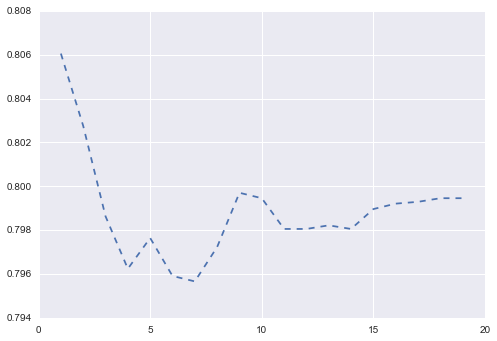

In [77]:
leafs = range(1,20,1)
scores = []
for leaf in leafs:
    clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=leaf)
    scores.append(cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');

In [58]:
clf = tree.DecisionTreeClassifier(class_weight=None, min_samples_leaf=3)
clf = clf.fit(train[features], y)

In [196]:
cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.76765186629132975

In [59]:
pd.crosstab(test['vacant'], clf.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,29478,1401
1,1546,1461


## xgboost

In [60]:
import xgboost as xgb

ImportError: No module named 'xgboost'

In [74]:
xgtest = test[features].as_matrix()
#create train and validation dmatrices 
xgtrain = train[features].as_matrix()

In [75]:
gbm = xgb.XGBClassifier(max_depth=50, n_estimators=100, learning_rate=0.1).fit(xgtrain, y)
predictions = gbm.predict(xgtest)
probs = gbm.predict_proba(xgtest)

In [76]:
pd.crosstab(test['vacant'],predictions)

col_0,0,1
vacant,,
0,30723,438
1,1585,1354


In [365]:
sound()

0.725076556652


pred,0.0,1.0
vacant,,
0,2431,438
1,777,1354


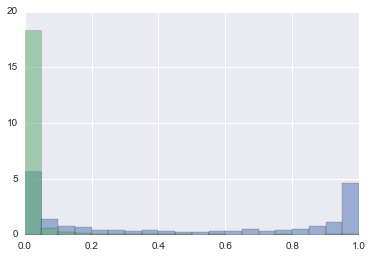

In [80]:
tem = test.copy()
tem['prob'] = probs[:,1]
tem['pred'] = tem.prob.apply(round)
plt.hist(tem[tem.vacant==1].prob.values,alpha=0.5,normed=True, bins=20);
plt.hist(tem[tem.vacant==0].prob.values,alpha=0.5,normed=True, bins=20);
print)sum(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant)*1.0/sum(tem.vacant))
pd.crosstab(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant,tem.sort_values('prob', ascending=False).iloc[0:5000].pred)

In [82]:
pd.crosstab(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant,tem.sort_values('prob', ascending=False).iloc[0:5000].pred)

pred,0.0,1.0
vacant,,
0,2431,438
1,777,1354


In [81]:
pd.crosstab(tem.sort_values('prob', ascending=False).iloc[0:5000].vacant,tem.sort_values('prob', ascending=False).iloc[0:5000].pred)

pred,0.0,1.0
vacant,,
0,2431,438
1,777,1354


In [107]:
features

['style__Bungalow',
 'style__CAP',
 'style__Colonial',
 'style__Other',
 'style__Ranch',
 'ext__Aluminum/Vinyl (r)',
 'ext__Brick',
 'ext__Frame (r)',
 'ext__Other',
 'lender__0',
 'lender__1501',
 'lender__2500',
 'lender__None',
 'propsize',
 'totusabl',
 'tmktval',
 'condition_value13',
 'condition_value14',
 'ownerocc_value',
 'totbldgs',
 'yrbuilt_filtered',
 'vacant_block',
 'median_rent',
 'property_crimes',
 'burglaries',
 'part_one_crimes',
 'part_two_crimes',
 'bachelors+',
 'poverty_rate',
 'median_hh_income',
 'white',
 'black',
 'asian',
 'other',
 'hispanic',
 'young',
 'middle',
 'old',
 'al_num',
 'al_days',
 't_days',
 't_shf_deed',
 't_num',
 'lb_acquired',
 'lb_tax_fc',
 'pv_total',
 'v_total_1yr',
 'v_total_2yr',
 'c_ovv_2yr',
 'c_ovv_1yr',
 'active_fc',
 'fc_1yr',
 'fc_2yr',
 'fc_days',
 'sa_days',
 'TAX_ASSESSED_LAND',
 'TAX_MARKET_LAND',
 'GRAND_TOTAL_BALANCE',
 'GRAND_TOTAL_BALANCE_14',
 'is_train']